# [Mood] CNNs Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os
import json
import pickle
import csv
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.utils import resample
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, ReLU
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
DRIVE_PATH = '/content/drive/My Drive/'
sys.path.append(DRIVE_PATH)

import utility
from utility import DataGenerator

MELSPECS_DIR = DRIVE_PATH + 'mood-melspecs-4544/'
SPLITS_DIR = DRIVE_PATH + 'mood-splits/'
RESULTS_DIR = DRIVE_PATH + 'mood-results/'
MODELS_DIR = DRIVE_PATH + 'mood-models/'
PICKLES_DIR = DRIVE_PATH + 'mood-pickles/'

NUM_EPOCHS = 15
BATCH_SIZE = 128

# 1. Loading the data


In [ ]:
# Loading the label map
with open(DRIVE_PATH + 'mood_label_map.json', 'r') as output:
    label_map = json.load(output)

label_map

{'ambiental': 0,
 'ballad': 1,
 'calm': 2,
 'christmas': 3,
 'cool': 4,
 'dark': 5,
 'deep': 6,
 'dream': 7,
 'emotional': 8,
 'energetic': 9,
 'fun': 10,
 'groovy': 11,
 'happy': 12,
 'holiday': 13,
 'hopeful': 14,
 'inspiring': 15,
 'love': 16,
 'meditative': 17,
 'melancholic': 18,
 'mellow': 19,
 'melodic': 20,
 'motivational': 21,
 'party': 22,
 'positive': 23,
 'powerful': 24,
 'relaxing': 25,
 'retro': 26,
 'romantic': 27,
 'sad': 28,
 'slow': 29,
 'soft': 30,
 'sport': 31,
 'summer': 32,
 'upbeat': 33,
 'uplifting': 34}

In [ ]:
all_tags = np.load(DRIVE_PATH + 'mood_all_tags.npy', allow_pickle=True)
NUM_CLASSES = len(all_tags)

In [ ]:
inv_label_map = {v: k for k, v in label_map.items()}

__Base split__

In [ ]:
# Loading the base split
X_train_filenames = np.load(SPLITS_DIR + 'base/X_train_filenames.npy')
X_val_filenames = np.load(SPLITS_DIR + 'base/X_val_filenames.npy')
X_test_filenames = np.load(SPLITS_DIR + 'base/X_test_filenames.npy')
one_hot_y_train = np.load(SPLITS_DIR + 'base/one_hot_y_train.npy')
one_hot_y_val = np.load(SPLITS_DIR + 'base/one_hot_y_val.npy')
one_hot_y_test = np.load(SPLITS_DIR + 'base/one_hot_y_test.npy')

In [ ]:
print('X_train shape:', X_train_filenames.shape)
print('y_train shape:', one_hot_y_train.shape)
print('X_val shape:', X_val_filenames.shape)
print('y_val shape:', one_hot_y_val.shape)
print('X_test shape:', X_test_filenames.shape)
print('y_test shape:', one_hot_y_test.shape)

X_train shape: (3635,)
y_train shape: (3635, 35)
X_val shape: (454,)
y_val shape: (454, 35)
X_test shape: (455,)
y_test shape: (455, 35)


__Resampling splits__

In [ ]:
sizes = [0.25, 0.5, 0.75, 1]

In [ ]:
# Upsample splits
X_train_filenames_upsample_list = [np.load(SPLITS_DIR + f'upsample/X_train_filenames_upsample_{size}.npy') for size in sizes]
one_hot_y_train_upsample_list = [np.load(SPLITS_DIR + f'upsample/one_hot_y_train_upsample_{size}.npy') for size in sizes]

In [ ]:
# Downsample splits
X_train_filenames_downsample_list = [np.load(SPLITS_DIR + f'downsample/X_train_filenames_downsample_{size}.npy') for size in sizes]
one_hot_y_train_downsample_list = [np.load(SPLITS_DIR + f'downsample/one_hot_y_train_downsample_{size}.npy') for size in sizes]

# 2. Creating generators

In [ ]:
# Replacing filenames by the absolute path to filenames
X_train_filenames = np.array([MELSPECS_DIR + fn for fn in X_train_filenames])
X_val_filenames = np.array([MELSPECS_DIR + fn for fn in X_val_filenames])
X_test_filenames = np.array([MELSPECS_DIR + fn for fn in X_test_filenames])

X_train_filenames_upsample_list = [np.array([MELSPECS_DIR + fn for fn in X_train_filenames_upsample]) 
                                    for X_train_filenames_upsample in X_train_filenames_upsample_list]

X_train_filenames_downsample_list = [np.array([MELSPECS_DIR + fn for fn in X_train_filenames_downsample]) 
                                     for X_train_filenames_downsample in X_train_filenames_downsample_list]

In [ ]:
# Determining mel spectrogram shape
x = np.load(X_train_filenames[0])
melspec_shape = x.shape
melspec_shape

(96, 341)

In [ ]:
# Generators for base split
train_generator_base = DataGenerator(X_train_filenames, one_hot_y_train, BATCH_SIZE, melspec_shape, 1)
validation_generator = DataGenerator(X_val_filenames, one_hot_y_val, BATCH_SIZE, melspec_shape, 1)
test_generator = DataGenerator(X_test_filenames, one_hot_y_test, BATCH_SIZE, melspec_shape, 1)

In [ ]:
train_generators_upsample_list = [DataGenerator(X_train_filenames, one_hot_y_train, BATCH_SIZE, melspec_shape, 1) 
                                  for X_train_filenames, one_hot_y_train in zip(X_train_filenames_upsample_list, one_hot_y_train_upsample_list)]

train_generators_downsample_list = [DataGenerator(X_train_filenames, one_hot_y_train, BATCH_SIZE, melspec_shape, 1) 
                                  for X_train_filenames, one_hot_y_train in zip(X_train_filenames_downsample_list, one_hot_y_train_downsample_list)]

# 3. Building and training the models

In [ ]:
def build_cnn(input_shape, output_shape=NUM_CLASSES, activation='sigmoid', dropout=0.5):
    
    # Input block
    melspec_input = Input(shape=input_shape, name='input')

    # Conv block 1
    x = Conv2D(32, (3, 3), padding='same', name='conv2D_1')(melspec_input)
    x = BatchNormalization(name='bn_1')(x)
    x = ReLU(name='relu_1')(x)
    x = MaxPooling2D((2, 4), name='pool_1')(x)
    x = Dropout(dropout, name='dropout_1')(x)
    
    
    # Conv block 2
    x = Conv2D(64, (3, 3), padding='same', name='conv2D_2')(x)
    x = BatchNormalization(name='bn_2')(x)
    x = ReLU(name='relu_2')(x)
    x = MaxPooling2D((2, 4), name='pool_2')(x)
    x = Dropout(dropout, name='dropout_2')(x)
    
    
    # Conv block 3
    x = Conv2D(128, (3, 3), padding='same', name='conv2D_3')(x)
    x = BatchNormalization(name='bn_3')(x)
    x = ReLU(name='relu_3')(x)
    x = MaxPooling2D((2, 3), name='pool_3')(x)
    x = Dropout(dropout, name='dropout_3')(x)
    

    # Conv block 4       
    x = Conv2D(256, (2, 2), padding='same', name='conv2D_4')(x)
    x = BatchNormalization(name='bn_4')(x)
    x = ReLU(name='relu_4')(x)
    x = MaxPooling2D((3, 5), name='pool_4')(x)
    x = Dropout(dropout, name='dropout_4')(x)

    
    # Conv block 5       
    x = Conv2D(512, (3, 3), padding='same', name='conv2D_5')(x)
    x = BatchNormalization(name='bn_5')(x)
    x = ReLU(name='relu_5')(x)
    x = MaxPooling2D((4, 1), name='pool_5')(x)
    x = Dropout(dropout, name='dropout_5')(x)
      
    # Flattening the output
    x = Flatten(name='flatten')(x)
    
    # Output Layer
    x = Dense(output_shape, activation=activation, name = 'dense_output')(x)
    
    # Create model
    model = Model(melspec_input, x)
    
    return model

In [ ]:
def create_checkpoint(filepath):
  checkpoint = ModelCheckpoint(filepath, 
                            monitor='val_auc', 
                            verbose=0, 
                            save_best_only=False)
  return checkpoint

In [ ]:
def plot_history(history_dict, num_epochs=NUM_EPOCHS, save_path=None):
    """[summary]

    Arguments:
        history {[type]} -- [description]
        num_epochs {[type]} -- [description]

    Keyword Arguments:
        save_path {[type]} -- [description] (default: {None})
    """

    plt.xticks(range(0, num_epochs))
    plt.plot(history_dict['loss'], marker='o', label='Training loss')
    plt.plot(history_dict['val_loss'], marker='d', label='Validation loss')
    plt.title('Loss evaluation')
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Training Epochs', fontsize=12)
    plt.grid()
    plt.legend()
    if save_path:
        plt.savefig(save_path + '_loss.jpg')
    plt.show()
    plt.close()

    plt.xticks(range(0, num_epochs))
    plt.plot(history_dict['auc'], marker='o', label='Training AUC')
    plt.plot(history_dict['val_auc'], marker='d', label='Validation AUC')
    plt.title('AUC evaluation')
    plt.ylabel('AUC', fontsize=12)
    plt.xlabel('Training Epochs', fontsize=12)
    plt.grid()
    plt.legend()
    if save_path:
        plt.savefig(save_path + '_auc.jpg')
    plt.show()

In [ ]:
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.1, 
                                         patience=1, 
                                         verbose=0)

auc = tf.keras.metrics.AUC()

In [ ]:
def train_cnn(checkpoint_path, train_generator, validation_generator, steps_per_epoch, plot_summary=False,
              input_shape=(melspec_shape[0], melspec_shape[1], 1), output_shape=NUM_CLASSES, activation='sigmoid', dropout=0.5):
  
  # Creating callbacks list
  callbacks_list = [create_checkpoint(checkpoint_path), reduce_lr_on_plateau]

  # Building the network
  cnn = build_cnn(input_shape=input_shape, output_shape=output_shape, activation=activation, dropout=dropout)
  if plot_summary:
    cnn.summary()

  # Compiling the network
  cnn.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(0.001),
              metrics=[auc])
  
  # Training the network
  cnn_hist = cnn.fit(x=train_generator,
                      epochs=NUM_EPOCHS,
                      steps_per_epoch=steps_per_epoch,
                      validation_data=validation_generator,
                      validation_steps=VAL_STEPS,
                      callbacks=callbacks_list)
  
  return cnn, cnn_hist

In [ ]:
VAL_STEPS = np.ceil(len(X_val_filenames)/BATCH_SIZE)
TEST_STEPS = np.ceil(len(X_test_filenames)/BATCH_SIZE)

## Base split

In [ ]:
steps_per_epoch = np.ceil(len(X_train_filenames)/BATCH_SIZE)
cnn_base, cnn_base_hist = train_cnn(checkpoint_path=MODELS_DIR + 'base/cnn_base_epoch_{epoch:02d}_auc_{auc:.4f}_val_auc_{val_auc:.4f}.h5',
                                    train_generator=train_generator_base,
                                    validation_generator=validation_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    plot_summary=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 96, 341, 1)]      0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 96, 341, 32)       320       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 96, 341, 32)       128       
_________________________________________________________________
relu_1 (ReLU)                (None, 96, 341, 32)       0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 48, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 85, 32)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 48, 85, 64)        18496 

In [ ]:
# Saving scores on train and validation sets
with open(PICKLES_DIR + 'cnn_base_history.pkl', 'wb') as f:
    pickle.dump(cnn_base_hist.history, f)

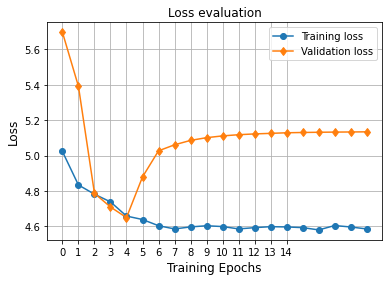

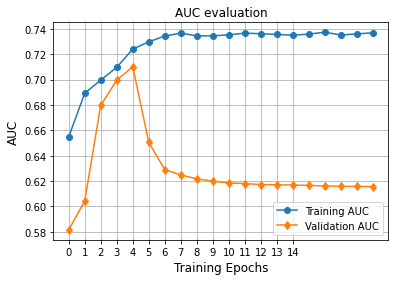

In [ ]:
# Loading scores
with open(PICKLES_DIR + 'cnn_base_history.pkl', 'rb') as f:
    cnn_base_hist = pickle.load(f)

plot_history(cnn_base_hist, num_epochs=NUM_EPOCHS, save_path=MODELS_DIR + 'base/cnn_base')

In [ ]:
# Loading the best performing model
cnn_base = load_model(filepath=MODELS_DIR + 'base/cnn_base_epoch_05_auc_0.7240_val_auc_0.7100.h5')

## Upsample splits

In [ ]:
for i, (size, train_generator_upsample) in enumerate(zip(sizes, train_generators_upsample_list)):
  print(f'\nUpsample size {size}')
  steps_per_epoch = np.ceil(len(X_train_filenames_upsample_list[i])/BATCH_SIZE)
  cnn_upsample, cnn_upsample_hist = train_cnn(checkpoint_path=MODELS_DIR + f'upsample/cnn_upsample_{size}_' + 'epoch_{epoch:02d}_auc_{auc:.4f}_val_auc_{val_auc:.4f}.h5',
                                    train_generator=train_generator_upsample,
                                    validation_generator=validation_generator,
                                    steps_per_epoch=steps_per_epoch)
  
  with open(PICKLES_DIR + f'cnn_upsample_{size}_history.pkl', 'wb') as f:
    pickle.dump(cnn_upsample_hist.history, f)


Upsample size 0.25
Epoch 1/15
39/39 [==============================] - 283s 7s/step - loss: 5.6593 - auc: 0.5454 - val_loss: 8.5138 - val_auc: 0.5400 - lr: 0.0010
Epoch 2/15
39/39 [==============================] - 286s 7s/step - loss: 4.9322 - auc: 0.5822 - val_loss: 5.8099 - val_auc: 0.5319 - lr: 0.0010
Epoch 3/15
39/39 [==============================] - 283s 7s/step - loss: 4.7754 - auc: 0.5953 - val_loss: 4.9917 - val_auc: 0.5796 - lr: 0.0010
Epoch 4/15
39/39 [==============================] - 285s 7s/step - loss: 4.7600 - auc: 0.5966 - val_loss: 4.8624 - val_auc: 0.6229 - lr: 0.0010
Epoch 5/15
39/39 [==============================] - 283s 7s/step - loss: 4.7474 - auc: 0.5942 - val_loss: 4.7978 - val_auc: 0.6496 - lr: 0.0010
Epoch 6/15
39/39 [==============================] - 283s 7s/step - loss: 4.7169 - auc: 0.6013 - val_loss: 4.7840 - val_auc: 0.6557 - lr: 0.0010
Epoch 7/15
39/39 [==============================] - 281s 7s/step - loss: 4.7129 - auc: 0.6029 - val_loss: 4.7926 - v


Upsample 0.25


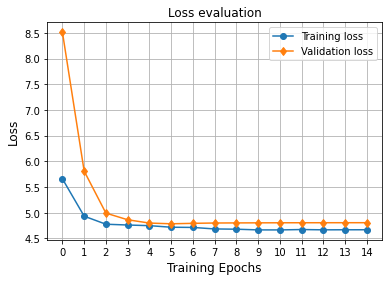

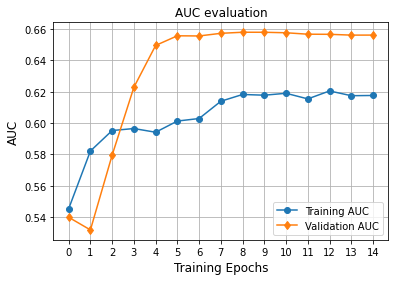


Upsample 0.5


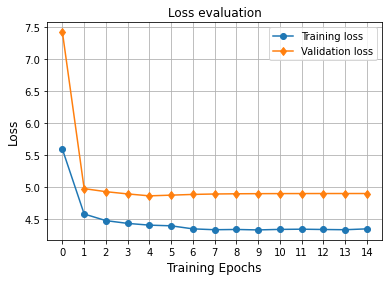

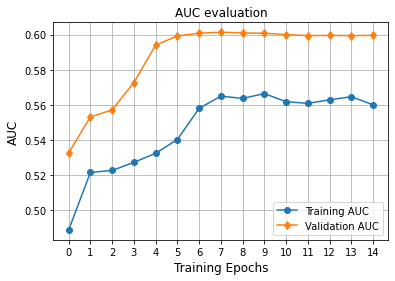


Upsample 0.75


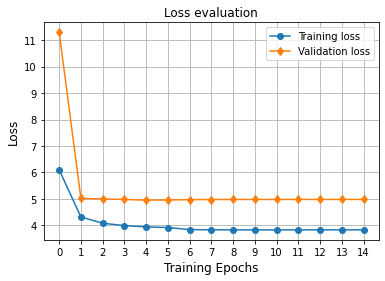

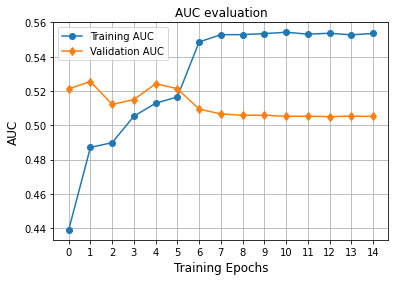


Upsample 1


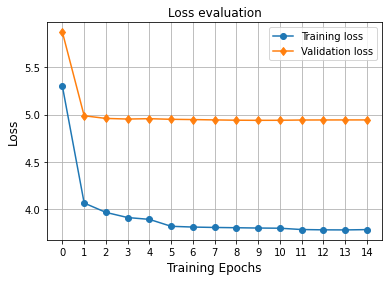

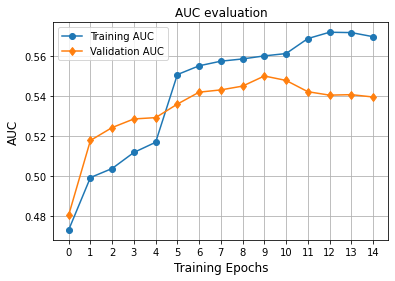

In [ ]:
# Loading scores
for size in sizes:
  print('\nUpsample', size)
  with open(PICKLES_DIR + f'cnn_upsample_{size}_history.pkl', 'rb') as f:
      cnn_hist = pickle.load(f)

  plot_history(cnn_hist, num_epochs=NUM_EPOCHS, save_path=MODELS_DIR + f'upsample/cnn_upsample_{size}')

In [ ]:
# Loading the best performing model 
cnn_upsample_025 = load_model(filepath=MODELS_DIR + 'upsample/cnn_upsample_0.25_epoch_09_auc_0.6183_val_auc_0.6580.h5')
cnn_upsample_05 = load_model(filepath=MODELS_DIR + 'upsample/cnn_upsample_0.5_epoch_08_auc_0.5649_val_auc_0.6013.h5')
cnn_upsample_075 = load_model(filepath=MODELS_DIR + 'upsample/cnn_upsample_0.75_epoch_02_auc_0.4871_val_auc_0.5256.h5')
cnn_upsample_1 = load_model(filepath=MODELS_DIR + 'upsample/cnn_upsample_1_epoch_10_auc_0.5600_val_auc_0.5499.h5')

## Downsample splits

In [ ]:
for i, (size, train_generator_downsample) in enumerate(zip(sizes, train_generators_downsample_list)):
  print(f'\nDownsample size {size}')
  steps_per_epoch = np.ceil(len(X_train_filenames_downsample_list[i])/BATCH_SIZE)
  cnn_downsample, cnn_downsample_hist = train_cnn(checkpoint_path=MODELS_DIR + f'downsample/cnn_downsample_{size}_' + 'epoch_{epoch:02d}_auc_{auc:.4f}_val_auc_{val_auc:.4f}.h5',
                                    train_generator=train_generator_downsample,
                                    validation_generator=validation_generator,
                                    steps_per_epoch=steps_per_epoch)
  
  with open(PICKLES_DIR + f'cnn_downsample_{size}_history.pkl', 'wb') as f:
    pickle.dump(cnn_downsample_hist.history, f)


Downsample size 0.25
Epoch 1/15
26/26 [==============================] - 755s 29s/step - loss: 5.1035 - auc: 0.4879 - val_loss: 13.4286 - val_auc: 0.5478 - lr: 0.0010
Epoch 2/15
26/26 [==============================] - 190s 7s/step - loss: 3.7745 - auc: 0.6500 - val_loss: 10.3327 - val_auc: 0.5908 - lr: 0.0010
Epoch 3/15
26/26 [==============================] - 195s 8s/step - loss: 3.5545 - auc: 0.6620 - val_loss: 6.6127 - val_auc: 0.6108 - lr: 0.0010
Epoch 4/15
26/26 [==============================] - 196s 8s/step - loss: 3.4855 - auc: 0.6686 - val_loss: 5.2699 - val_auc: 0.6379 - lr: 0.0010
Epoch 5/15
26/26 [==============================] - 193s 7s/step - loss: 3.4702 - auc: 0.6698 - val_loss: 4.8936 - val_auc: 0.6512 - lr: 0.0010
Epoch 6/15
26/26 [==============================] - 193s 7s/step - loss: 3.4319 - auc: 0.6777 - val_loss: 4.7799 - val_auc: 0.6556 - lr: 0.0010
Epoch 7/15
26/26 [==============================] - 192s 7s/step - loss: 3.4311 - auc: 0.6781 - val_loss: 4.750


Downsample 0.25


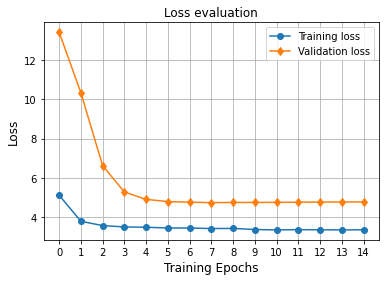

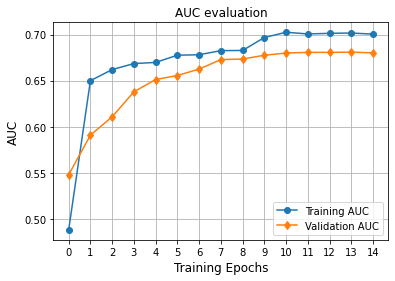


Downsample 0.5


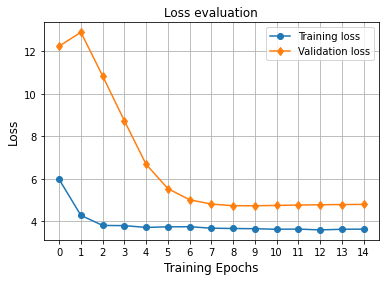

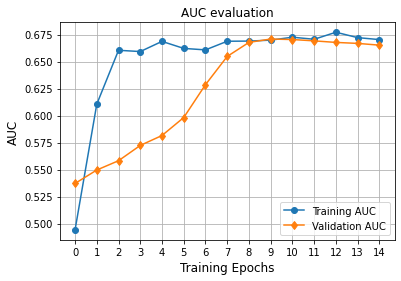


Downsample 0.75


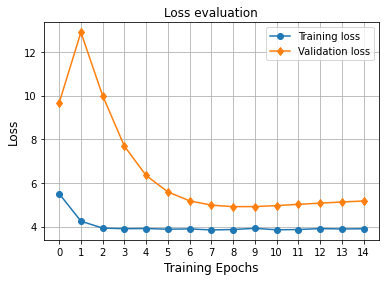

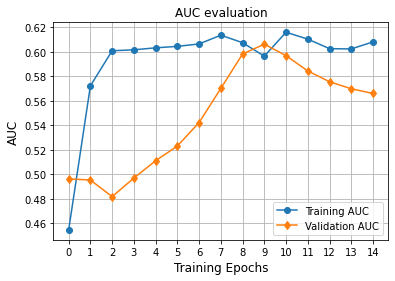


Downsample 1


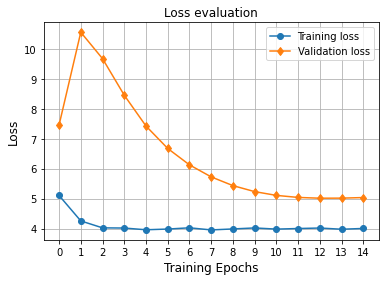

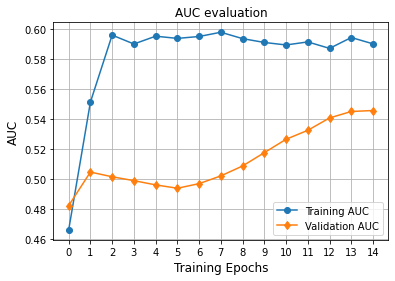

In [ ]:
# Loading scores
for size in sizes:
  print('\nDownsample', size)
  with open(PICKLES_DIR + f'cnn_downsample_{size}_history.pkl', 'rb') as f:
      cnn_hist = pickle.load(f)

  plot_history(cnn_hist, num_epochs=NUM_EPOCHS, save_path=MODELS_DIR + f'downsample/cnn_downsample_{size}')

In [ ]:
# Loading the best performing model 
cnn_downsample_025 = load_model(filepath=MODELS_DIR + 'downsample/cnn_downsample_0.25_epoch_12_auc_0.7007_val_auc_0.6807.h5')
cnn_downsample_05 = load_model(filepath=MODELS_DIR + 'downsample/cnn_downsample_0.5_epoch_10_auc_0.6698_val_auc_0.6708.h5')
cnn_downsample_075 = load_model(filepath=MODELS_DIR + 'downsample/cnn_downsample_0.75_epoch_10_auc_0.5963_val_auc_0.6061.h5')
cnn_downsample_1 = load_model(filepath=MODELS_DIR + 'downsample/cnn_downsample_1_epoch_14_auc_0.5946_val_auc_0.5452.h5')

# 4. Save scores


In [ ]:
header = ['model', 'accuracy', 'precision_samples', 'recall_samples', 'f1_score_samples', 'roc_auc_samples']

with open(RESULTS_DIR + 'mood_all_models_scores.csv', 'w') as csv_file:
  writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
  writer.writerow(header)

In [ ]:
def make_predictions(model):
  pred_proba = model.predict(x=test_generator, steps=TEST_STEPS)
  one_hot_y_pred = np.array([[1 if val == True else 0 for val in pred > 0.9] for pred in pred_proba])
  return pred_proba, one_hot_y_pred

In [ ]:
def compute_scores(one_hot_y_pred, one_hot_y_true):
  accuracy = accuracy_score(one_hot_y_true, one_hot_y_pred, normalize=True, sample_weight=None)
  precision_samples = precision_score(one_hot_y_true, one_hot_y_pred, average='samples', zero_division=1)
  recall_samples = recall_score(one_hot_y_true, one_hot_y_pred, average='samples')
  f1_score_samples = f1_score(one_hot_y_true, one_hot_y_pred, average='samples')
  roc_auc_samples = roc_auc_score(one_hot_y_true, one_hot_y_pred, average='samples')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision_samples}')
  print(f'Recall: {recall_samples}')
  print(f'F1-score: {f1_score_samples}')
  print(f'ROC AUC: {roc_auc_samples}')

  return accuracy, precision_samples, recall_samples, f1_score_samples, roc_auc_samples

In [ ]:
def save_scores(model_name, one_hot_y_pred, one_hot_y_true=one_hot_y_test):
  scores = compute_scores(one_hot_y_pred=one_hot_y_pred, one_hot_y_true=one_hot_y_true) 

  row = [model_name]
  row.extend(scores)
  
  with open(RESULTS_DIR + 'mood_all_models_scores.csv', 'a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(row)
  

In [ ]:
# Base model
# Making predictions on test set
pred_proba_base, one_hot_y_pred_base = make_predictions(cnn_base)

# Computing and saving scores
model_name = 'cnn_base'
save_scores(model_name=model_name, one_hot_y_pred=one_hot_y_pred_base)

Accuracy: 0.0
Precision: 0.08376289766399656
Recall: 0.43065934065934064
F1-score: 0.1348085492041536
ROC AUC: 0.6197749931996726


In [ ]:
models_upsample = [cnn_upsample_025, cnn_upsample_05, cnn_upsample_075, cnn_upsample_1]
predictions_proba_upsample = []

for size, model in zip(sizes, models_upsample):
  print(f'\nCNN-Upsample-{size}')

  # Making predictions on test set
  pred_proba, y_pred = make_predictions(model)
  predictions_proba_upsample.append(pred_proba)
  
  # Computing and saving scores
  model_name = f'cnn_upsample_{size}'
  save_scores(model_name=model_name, one_hot_y_pred=y_pred)


CNN-Upsample-0.25
Accuracy: 0.0
Precision: 0.08274725274725274
Recall: 0.241025641025641
F1-score: 0.11794174079888366
ROC AUC: 0.5651826653384349

CNN-Upsample-0.5
Accuracy: 0.013186813186813187
Precision: 0.8835164835164835
Recall: 0.015018315018315017
F1-score: 0.01575091575091575
ROC AUC: 0.5056103644931919

CNN-Upsample-0.75
Accuracy: 0.0
Precision: 0.28093331660946064
Recall: 0.5498168498168499
F1-score: 0.0614740455473142
ROC AUC: 0.5223068886091117

CNN-Upsample-1
Accuracy: 0.002197802197802198
Precision: 0.842816872669814
Recall: 0.026373626373626374
F1-score: 0.009145066933656054
ROC AUC: 0.5007887905895496


In [ ]:
models_downsample = [cnn_downsample_025, cnn_downsample_05, cnn_downsample_075, cnn_downsample_1]
predictions_proba_downsample = []

for size, model in zip(sizes, models_downsample):
  print(f'\nCNN-Downsample-{size}')

  # Making predictions on test set
  pred_proba, y_pred = make_predictions(model)
  predictions_proba_downsample.append(pred_proba)
  
  # Computing and saving scores
  model_name = f'cnn_downsample_{size}'
  save_scores(model_name=model_name, one_hot_y_pred=y_pred)


CNN-Downsample-0.25
Accuracy: 0.002197802197802198
Precision: 0.8846153846153846
Recall: 0.01941391941391941
F1-score: 0.013699633699633697
ROC AUC: 0.5064650186151609

CNN-Downsample-0.5
Accuracy: 0.0
Precision: 0.9934065934065934
Recall: 0.0
F1-score: 0.0
ROC AUC: 0.499901079312844

CNN-Downsample-0.75
Accuracy: 0.02857142857142857
Precision: 0.4087912087912088
Recall: 0.05091575091575091
F1-score: 0.047619047619047616
ROC AUC: 0.5124144743618178

CNN-Downsample-1
Accuracy: 0.0
Precision: 0.9626373626373627
Recall: 0.002197802197802198
F1-score: 0.0029304029304029304
ROC AUC: 0.500545532898474


Perform no better than a popularity baseline that always predicts the most frequent tag among tracks in the training set. I am unable to explain this result. There might be a mistake in one of those steps:
- Data preparation
- CNN Architecture
- Threshold in make_predictions
- Metrics 